In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model and reflect tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [32]:
#take a look at the columns of the measurement table

first_row_m = session.query(measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22170e61cd0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [33]:
#take a look at the columns of the station table

first_row_s = session.query(station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22170e95640>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716}

In [53]:
# Find the most recent date in the data set
from sqlalchemy import desc
most_recent = session.query(measurement).order_by(desc('date')).first().__dict__
most_recent

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2217024c1f0>,
 'prcp': 0.0,
 'station': 'USC00519397',
 'tobs': 81.0,
 'date': '2017-08-23',
 'id': 2724}

In [63]:
# Retrieve last year of data from most recent data point
# Perform a query to retrieve the data and precipitation scores

last_year_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-23').\
        filter(measurement.date <= '2017-08-23').all()


In [78]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_year_precip, columns=['Date', 'Precipitation'])
precip_df = precip_df.set_index('Date')
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [77]:
# Sort the dataframe by date
precip_df = precip_df.sort_index()
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


<AxesSubplot:xlabel='Date'>

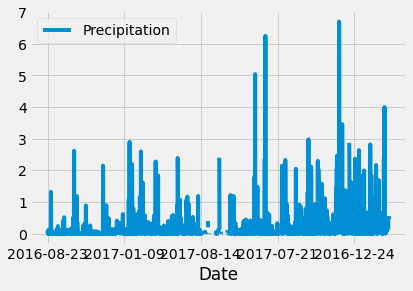

In [79]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()

In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()